In [60]:
# use new database file to plot
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle, Polygon
import collections

import math

from functools import partial
import pyproj

import folium
import geopandas as gpd
from shapely import wkb
from shapely.geometry import shape, mapping, box ,Point
from shapely import ops, affinity

from binascii import unhexlify
from codecs import encode
import pysal
import load_csv
# Raster Modules
import rasterio
from rasterio import mask
import rasterio.plot as rioplot
from rasterstats import zonal_stats, point_query

import seaborn as sns
#%matplotlib tk
%matplotlib inline

In [1]:
# MONTH
# DAY OF WEEK
# HOUR OF DAY
# IfHoliday
# ROAD CLASS

# highway
# footway
# surface
# lighting
# side wald
# NUM OF LANE
# ONEWAY
# SPEED LIMIT
# RoadFunctionality
# road curvature???

# AADT
# WEATHER --- TEMPORATURE --ICING

# population density??



In [2]:
db_name = "data/michigan/michigan.sqlite"

conn = sqlite3.connect(db_name)
conn.enable_load_extension(True)
conn.load_extension("mod_spatialite")

In [5]:
query = """
        SELECT *
        FROM Accident_2016
        """
tunnel_map = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='Geometry',crs={"init":"epsg:4326"})
tunnel_map.head(5)

AttributeError: 'buffer' object has no attribute 'encode'

In [10]:
census_path = 'data/michigan/census2010/mi_census.tif'
census_raster = rasterio.open(census_path)
census_raster.meta

{'affine': Affine(59.999779809819536, 0.0, 364431.4905564219,
       0.0, -59.99939823163751, 2807326.803222203),
 'count': 1,
 'crs': CRS({u'lon_0': -96, u'ellps': u'GRS80', u'y_0': 0, u'no_defs': True, u'proj': u'aea', u'x_0': 0, u'units': u'm', u'towgs84': u'0,0,0,0,0,0,0', u'lat_2': 45.5, u'lat_1': 29.5, u'lat_0': 23}),
 'driver': u'GTiff',
 'dtype': 'int32',
 'height': 12462,
 'nodata': -2147483647.0,
 'transform': (364431.4905564219,
  59.999779809819536,
  0.0,
  2807326.803222203,
  0.0,
  -59.99939823163751),
 'width': 17026}

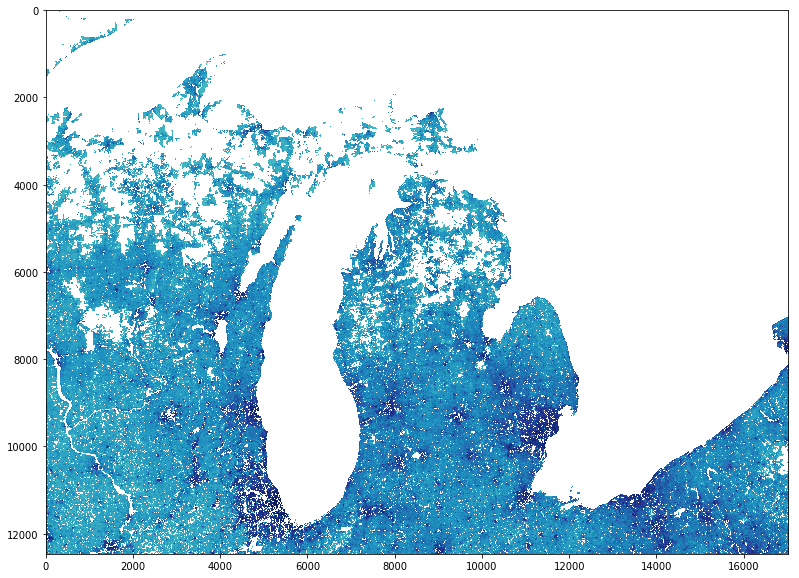

In [19]:
# Plot the Data using a logarithmic scale
fig = plt.figure(figsize=(20,10))
rioplot.show(census_raster, cmap="YlGnBu", norm=LogNorm(vmin=0.0001, vmax=10000), with_bounds=True);

In [13]:
# file_path = 'data/michigan/accident/shrinked_accident.csv'
file_path = 'MI_data_2016.csv'
crash = load_csv.run(file_path)

In [14]:
crash['lat'] = map(float, crash['lat'])
crash['lon'] = map(float,crash['lon'])
crash['nhour'] = map(int, crash['nhour'])
crash['day_of_week'] = map(int, crash['day_of_week'])
crash['cmonth'] = map(int, crash['cmonth'])
crash['num_lanes'] = map(int, crash['num_lanes'])
crash['speed_limit'] = map(int, crash['speed_limit'])
crash['rdwy_area_cd'] = map(int, crash['rdwy_area_cd'])
# for i in range(len(crash['rd_cond_cd'])):
#     if crash['rd_cond_cd'][i] == '*':
#         crash['rd_cond_cd'][i] = 99
crash['rd_cond_cd'] = map(int, crash['rd_cond_cd'])
crash['wthr_cd_2016'] = map(int, crash['wthr_cd_2016'])
crash['rurl_urb_left_cd'] = map(int, crash['rurl_urb_left_cd'])
crash['rurl_urb_rght_cd'] = map(int, crash['rurl_urb_rght_cd'])
crash['crsh_type_cd'] = map(int, crash['crsh_type_cd'])
crash['cnty_cd'] = map(int, crash['cnty_cd'])
# for i in range(len(crash['hwy_clss_cd'])):
#     if crash['hwy_clss_cd'][i] == '*':
#         crash['hwy_clss_cd'][i] = 99
crash['hwy_clss_cd'] = map(int, crash['hwy_clss_cd'])
crash['rd_rltn_cd'] = map(int, crash['rd_rltn_cd'])
# for i in range(len(crash['hwy_clss_cd'])):
#     if crash['hwy_clss_cd'][i] == '*':
#         crash['hwy_clss_cd'][i] = 99


In [64]:
f = plt.figure(figsize=(10,6),dpi=80)
sns.countplot(x="rd_rltn_cd",data=crash)
plt.xlabel('Crash_road_relationship', fontsize=18)
plt.ylabel('Number of accidents', fontsize=18)
plt.savefig('data/michigan/example_img/crash_road_relationship.png')

{'type': 'Polygon', 'coordinates': [[[-84.14555700000001, 42.649815000000004], [-84.143557, 42.649815000000004], [-84.143557, 42.651815], [-84.14555700000001, 42.651815]]]}


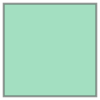

In [51]:
# indicate a crash point
crash_point = {
        "type": "Polygon",
        "coordinates": [
            [
                [
               float(crash['lon'][0])-0.001,
               float(crash['lat'][0]-0.001)    
              ],
                [
               float(crash['lon'][0]+0.001),
               float(crash['lat'][0]-0.001)    
              ],
                [
               float(crash['lon'][0]+0.001),
               float(crash['lat'][0]+0.001)    
              ],
                [
               float(crash['lon'][0]-0.001),
               float(crash['lat'][0]+0.001)    
              ],
            ]
        ]
      }
print(crash_point)
crash_point = shape(crash_point)
crash_point

In [52]:
# crash_point = Point(float(crash['lon'][0]),float(crash['lat'][0]))#shape(area_dict)

project = partial(
                pyproj.transform,
                pyproj.Proj(init='epsg:4326'),
                pyproj.Proj(init='epsg:5070'))
crash_point = ops.transform(project, crash_point)

In [53]:
zs = zonal_stats(crash_point, census_raster.read(1), affine=census_raster.affine, nodata=-999)[0]

In [58]:
def rowcol(transform, xs, ys, op=math.floor, precision=6):
    """
    Returns the rows and cols of the pixels containing (x, y) given a
    coordinate reference system.
    Use an epsilon, magnitude determined by the precision parameter
    and sign determined by the op function:
        positive for floor, negative for ceil.
    Parameters
    ----------
    transform : Affine
        Coefficients mapping pixel coordinates to coordinate reference system.
    xs : list or float
        x values in coordinate reference system
    ys : list or float
        y values in coordinate reference system
    op : function
        Function to convert fractional pixels to whole numbers (floor, ceiling,
        round)
    precision : int
        Decimal places of precision in indexing, as in `round()`.
    Returns
    -------
    rows : list of ints
        list of row indices
    cols : list of ints
        list of column indices
    """

    single_x = False
    single_y = False
    if not isinstance(xs, collections.Iterable):
        xs = [xs]
        single_x = True
    if not isinstance(ys, collections.Iterable):
        ys = [ys]
        single_y = True

    eps = 10.0 ** -precision * (1.0 - 2.0 * op(0.1))
    invtransform = ~transform

    rows = []
    cols = []
    for x, y in zip(xs, ys):
        fcol, frow = invtransform * (x + eps, y - eps)
        cols.append(op(fcol))
        rows.append(op(frow))

    if single_x:
        cols = cols[0]
    if single_y:
        rows = rows[0]

    return rows, cols
def get_index(coords, affine):
    return np.asarray(rowcol(affine, coords[0], coords[1]))[::-1]

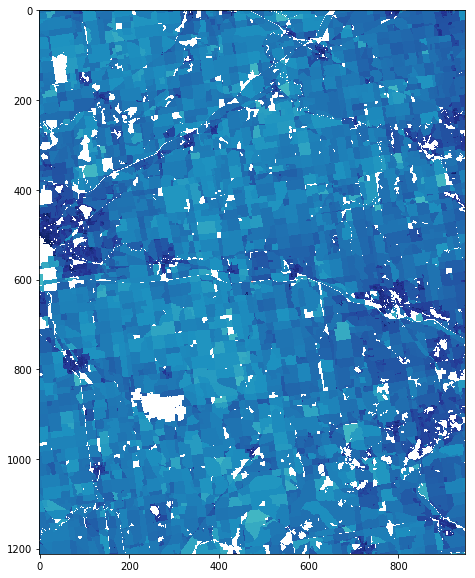

In [65]:
large_area = box(*affinity.scale(crash_point, xfact=300, yfact=300).bounds) # enlarge the area so we can see its context (surroundings)
# Crop the raster to see only the enlarged_area
enlarged_window, affine = mask.mask(
            census_raster, [mapping(large_area)], crop=True)
# Create a patch of red to highlight the area of interest against the census data
area_pixels = np.asarray([ get_index(coords, affine) for coords in np.asarray(crash_point.exterior.coords)], dtype=np.int32)

fig = plt.figure(figsize=(20,10) )
ax = fig.add_subplot(111)
rioplot.show(enlarged_window,ax=ax,cmap="YlGnBu", norm=LogNorm(vmin=0.0001, vmax=10000), with_bounds=True)
ax.add_patch(Polygon(area_pixels, alpha=.2, color='r'))

In [ ]:
# indicate a crash point

crash_point = {
        "type": "Polygon",
        "coordinates": [
            [
                [
               float(crash['lon'][0])-0.001,
               float(crash['lat'][0]-0.001)    
              ],
                [
               float(crash['lon'][0]+0.001),
               float(crash['lat'][0]-0.001)    
              ],
                [
               float(crash['lon'][0]+0.001),
               float(crash['lat'][0]+0.001)    
              ],
                [
               float(crash['lon'][0]-0.001),
               float(crash['lat'][0]+0.001)    
              ],
            ]
        ]
      }
print(crash_point)
crash_point = shape(crash_point)
crash_point